<a href="https://colab.research.google.com/github/alawrence30/Deep-Learning/blob/main/6_8_Assignment_4_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#https://www.kaggle.com/code/tilasousa/face-mask-detection-using-keras-cnn

# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import cv2
from scipy.spatial import distance
import glob
from warnings import filterwarnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import classification_report , confusion_matrix
from skimage import io
filterwarnings("ignore")

from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import load_img


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow_datasets as tfds
from keras import callbacks
from sklearn.metrics import accuracy_score
from os import listdir
from os.path import isfile, join

In [3]:
## Accuracy and Loss Graph
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

## Validation Report
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

## Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

# defining callback function to avoid overfit
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 6, 
                                        restore_best_weights = True, verbose=1)

# EDA

The path is created for getting data and then I concatened dataframes of mask and without mask.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
path  = '/content/gdrive/My Drive/MSDS 458/Assignment 4 - Final/Data/Face Mask Dataset/'

In [6]:
# train dataset
train_dir = os.path.join(path, 'Train')

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            batch_size=32,
                                                            image_size=(256,256),
                                                            shuffle=True)

Found 10000 files belonging to 2 classes.


In [7]:
# validation dataset
validation_dir = os.path.join(path, 'Validation')

validation_ds = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                            batch_size=32,
                                                            image_size=(256,256),
                                                            shuffle=True)

Found 800 files belonging to 2 classes.


In [8]:
# test dataset
test_dir = os.path.join(path, 'Test')

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            batch_size=32,
                                                            image_size=(256,256),
                                                            shuffle=True)

Found 992 files belonging to 2 classes.


In [9]:
class_names = train_ds.class_names
print(class_names)

['WithMask', 'WithoutMask']


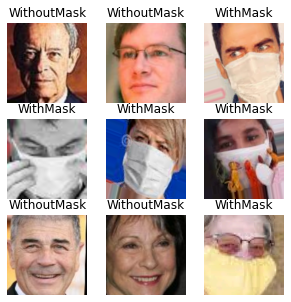

In [10]:
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
# autotune buffer to avoid I/0 block
autotune = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=autotune)
validation_ds = validation_ds.cache().prefetch(buffer_size=autotune)

# Model 6

Base: Model 3 - best 85%

Sequential model

Input layer

Hidden layer 1: Dense 250 units, Relu activation + Dropout (0.30)

Hidden layer 2: Dense 350 units, Relu activation + Dropout (0.30)

Hidden layer 3: Dense 250 units, Relu activation + Dropout (0.30)

Hidden layer 4: Dense 100 units, Relu activation + Dropout (0.30)

Output layer: Dense 2 units, Softmax activation

In [12]:
model6 = Sequential()
tf.keras.layers.Rescaling(1./255),
model6.add(keras.layers.Flatten(input_shape = [256, 256, 3]))
model6.add(layers.Dense(units = 250, activation = "relu"))
model6.add(Dropout(0.30))
model6.add(layers.Dense(units = 350, activation = "relu"))
model6.add(Dropout(0.30))
model6.add(layers.Dense(units = 250, activation = "relu"))
model6.add(Dropout(0.30))
model6.add(layers.Dense(units = 100, activation = "relu"))
model6.add(Dropout(0.30))
model6.add(layers.Dense(name = "output_layer", units = 2, activation = "softmax"))

model6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 250)               49152250  
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 350)               87850     
                                                                 
 dropout_1 (Dropout)         (None, 350)               0         
                                                                 
 dense_2 (Dense)             (None, 250)               87750     
                                                                 
 dropout_2 (Dropout)         (None, 250)               0

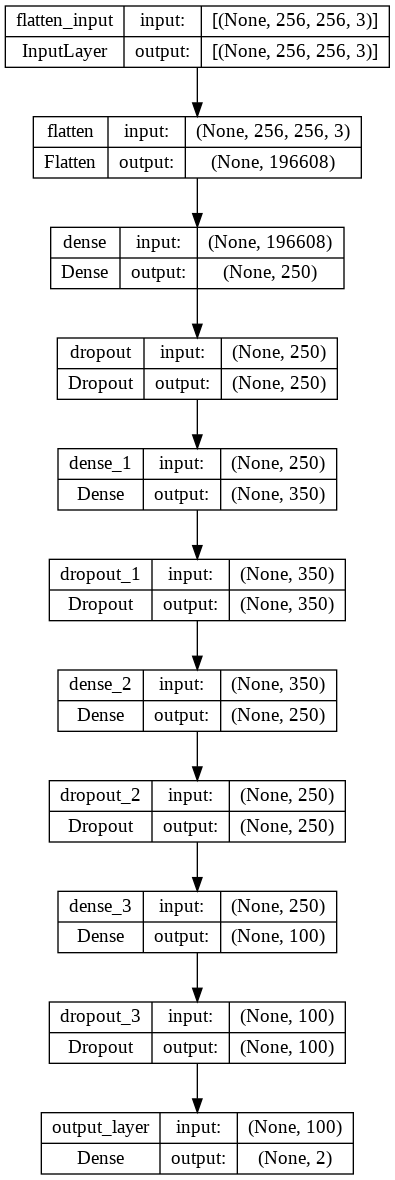

In [13]:
keras.utils.plot_model(model6, "model6.png", show_shapes=True) 

In [14]:
model6.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [15]:
## Train 
history6 = model6.fit(train_ds
                    ,validation_data =validation_ds
                    ,epochs=200
                    ,batch_size=64
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model6.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3),
                    ]                                                                                                           
                   )

Epoch 1/200
313/313 [==============================] - 184s 580ms/step - loss: 749.7808 - accuracy: 0.5330 - val_loss: 0.6866 - val_accuracy: 0.5138
Epoch 2/200
313/313 [==============================] - 3s 10ms/step - loss: 0.9054 - accuracy: 0.4976 - val_loss: 0.6915 - val_accuracy: 0.5025
Epoch 3/200
313/313 [==============================] - 3s 10ms/step - loss: 0.7361 - accuracy: 0.4960 - val_loss: 0.7023 - val_accuracy: 0.5038
Epoch 4/200
313/313 [==============================] - 3s 10ms/step - loss: 0.7031 - accuracy: 0.5015 - val_loss: 0.6872 - val_accuracy: 0.5088


In [16]:
model6 = tf.keras.models.load_model("DNN_model6.h5")
print(f"Test acc: {model6.evaluate(test_ds)[1]:.3f}")

31/31 [==============================] - 20s 464ms/step - loss: 0.6832 - accuracy: 0.5272
Test acc: 0.527


## Evaluate

In [17]:
history_dict6 = history6.history
history_dict6.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [18]:
history_df6=pd.DataFrame(history_dict6)
history_df6.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,749.781,0.533,0.687,0.514
1,0.905,0.498,0.692,0.502
2,0.736,0.496,0.702,0.504
3,0.703,0.502,0.687,0.509


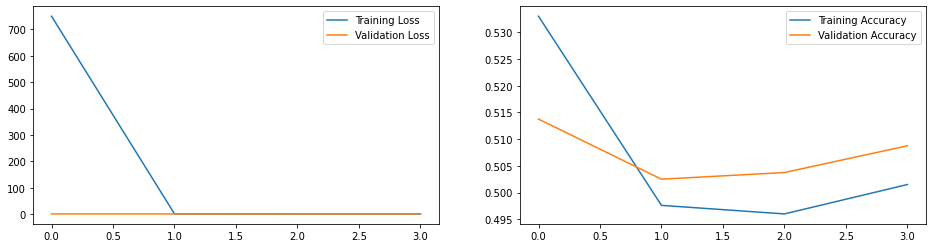

In [19]:
## Loss and acuracy
plot_history(history6)

In [20]:
test_pred6 = model6.predict(test_ds)
test_pred6 = np.argmax(test_pred6,axis = 1)
test_labels6 = np.concatenate([y for x, y in test_ds], axis=0) 

31/31 [==============================] - 1s 16ms/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

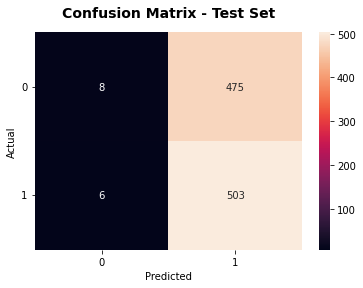

In [21]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels6,
    test_pred6,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 10) 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 14,weight = 'bold',pad=15)

In [22]:
# 0 = without mask, 1 = with mask
# 992 images in test set, model missed 0 with mask and 483 without mask

# Model 7

Sequential model

Input layer

Hidden layer 1: Dense 250 units, Relu activation + Dropout (0.30)

Hidden layer 2: Dense 350 units, Relu activation + Dropout (0.30)

Output layer: Dense 2 units, Softmax activation

In [39]:
model7 = Sequential()
tf.keras.layers.Rescaling(1./255),
model7.add(keras.layers.Flatten(input_shape = [256, 256, 3]))
model7.add(layers.Dense(units = 250, activation = "relu"))
model7.add(Dropout(0.10))
model7.add(layers.Dense(units = 350, activation = "relu"))
model7.add(Dropout(0.10))
model7.add(layers.Dense(name = "output_layer", units = 2, activation = "softmax"))

model7.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 196608)            0         
                                                                 
 dense_12 (Dense)            (None, 250)               49152250  
                                                                 
 dropout_12 (Dropout)        (None, 250)               0         
                                                                 
 dense_13 (Dense)            (None, 350)               87850     
                                                                 
 dropout_13 (Dropout)        (None, 350)               0         
                                                                 
 output_layer (Dense)        (None, 2)                 702       
                                                                 
Total params: 49,240,802
Trainable params: 49,240,802


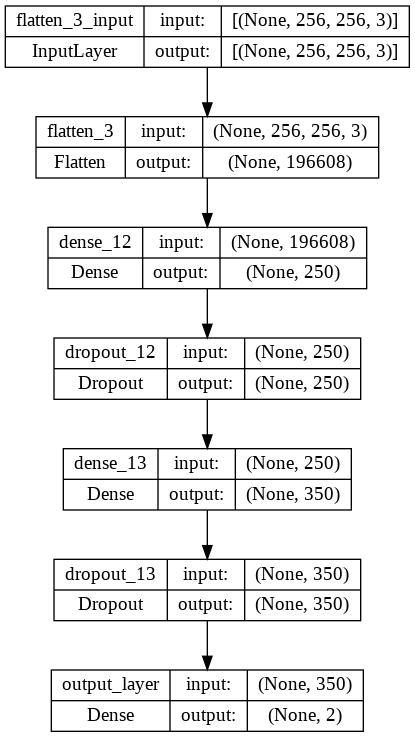

In [41]:
keras.utils.plot_model(model7, "model7.png", show_shapes=True) 

In [43]:
model7.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [44]:
## Train 
history7 = model7.fit(train_ds
                    ,validation_data =validation_ds
                    ,epochs=200
                    ,batch_size=64
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model7.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3),
                    ]                                                                                                           
                   )

Epoch 1/200
313/313 [==============================] - 5s 15ms/step - loss: 786.2490 - accuracy: 0.6240 - val_loss: 0.6258 - val_accuracy: 0.5938
Epoch 2/200
313/313 [==============================] - 3s 10ms/step - loss: 0.6662 - accuracy: 0.6086 - val_loss: 0.6504 - val_accuracy: 0.5612
Epoch 3/200
313/313 [==============================] - 3s 11ms/step - loss: 0.6589 - accuracy: 0.5514 - val_loss: 0.6658 - val_accuracy: 0.5400
Epoch 4/200
313/313 [==============================] - 4s 14ms/step - loss: 0.6465 - accuracy: 0.5773 - val_loss: 0.5782 - val_accuracy: 0.6500
Epoch 5/200
313/313 [==============================] - 3s 10ms/step - loss: 0.6673 - accuracy: 0.5482 - val_loss: 0.6604 - val_accuracy: 0.5475
Epoch 6/200
313/313 [==============================] - 3s 10ms/step - loss: 0.7043 - accuracy: 0.5605 - val_loss: 0.6893 - val_accuracy: 0.5063
Epoch 7/200
313/313 [==============================] - 3s 10ms/step - loss: 0.6865 - accuracy: 0.5081 - val_loss: 0.6873 - val_accurac

In [45]:
model7 = tf.keras.models.load_model("DNN_model7.h5")
print(f"Test acc: {model7.evaluate(test_ds)[1]:.3f}")

31/31 [==============================] - 1s 16ms/step - loss: 1.3376 - accuracy: 0.6754
Test acc: 0.675


## Evaluate

In [46]:
history_dict7 = history7.history
history_dict7.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [47]:
history_df7=pd.DataFrame(history_dict7)
history_df7.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
2,0.659,0.551,0.666,0.540
3,0.646,0.577,0.578,0.650
4,0.667,0.548,0.660,0.548
5,0.704,0.561,0.689,0.506
6,0.686,0.508,0.687,0.509


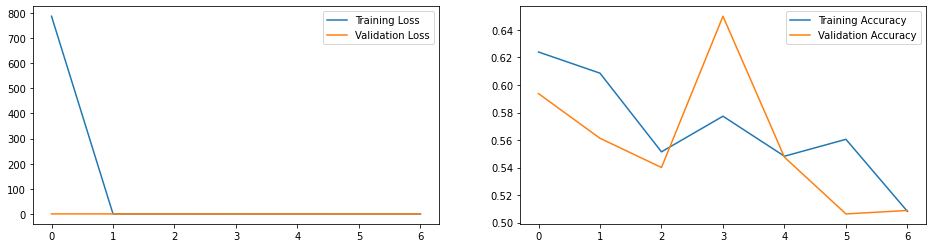

In [48]:
## Loss and acuracy
plot_history(history7)

In [49]:
test_pred7 = model7.predict(test_ds)
test_pred7 = np.argmax(test_pred7,axis = 1)
test_labels7 = np.concatenate([y for x, y in test_ds], axis=0) 

31/31 [==============================] - 1s 18ms/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

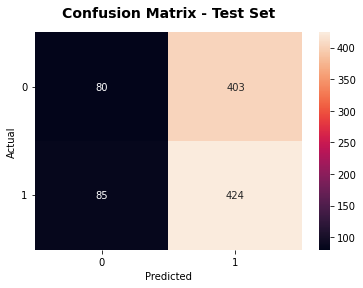

In [50]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels7,
    test_pred7,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 10) 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 14,weight = 'bold',pad=15)

In [ ]:
# 0 = without mask, 1 = with mask
# 992 images in test set, model missed 85 with mask and 403 without mask

# Model 8

Base: Model 3 - best 85%

Sequential model

Input layer

Hidden layer 1: Dense 250 units, Relu activation + Dropout (0.10)

Hidden layer 2: Dense 350 units, Relu activation + Dropout (0.10)

Hidden layer 3: Dense 250 units, Relu activation + Dropout (0.10)

Hidden layer 4: Dense 100 units, Relu activation + Dropout (0.10)

Output layer: Dense 2 units, Softmax activation

In [29]:
model8 = Sequential()
tf.keras.layers.Rescaling(1./255),
model8.add(keras.layers.Flatten(input_shape = [256, 256, 3]))
model8.add(layers.Dense(units = 250, activation = "relu"))
model8.add(Dropout(0.10))
model8.add(layers.Dense(units = 350, activation = "relu"))
model8.add(Dropout(0.10))
model8.add(layers.Dense(units = 250, activation = "relu"))
model8.add(Dropout(0.10))
model8.add(layers.Dense(units = 100, activation = "relu"))
model8.add(Dropout(0.10))
model8.add(layers.Dense(name = "output_layer", units = 2, activation = "softmax"))

model8.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 196608)            0         
                                                                 
 dense_8 (Dense)             (None, 250)               49152250  
                                                                 
 dropout_8 (Dropout)         (None, 250)               0         
                                                                 
 dense_9 (Dense)             (None, 350)               87850     
                                                                 
 dropout_9 (Dropout)         (None, 350)               0         
                                                                 
 dense_10 (Dense)            (None, 250)               87750     
                                                                 
 dropout_10 (Dropout)        (None, 250)              

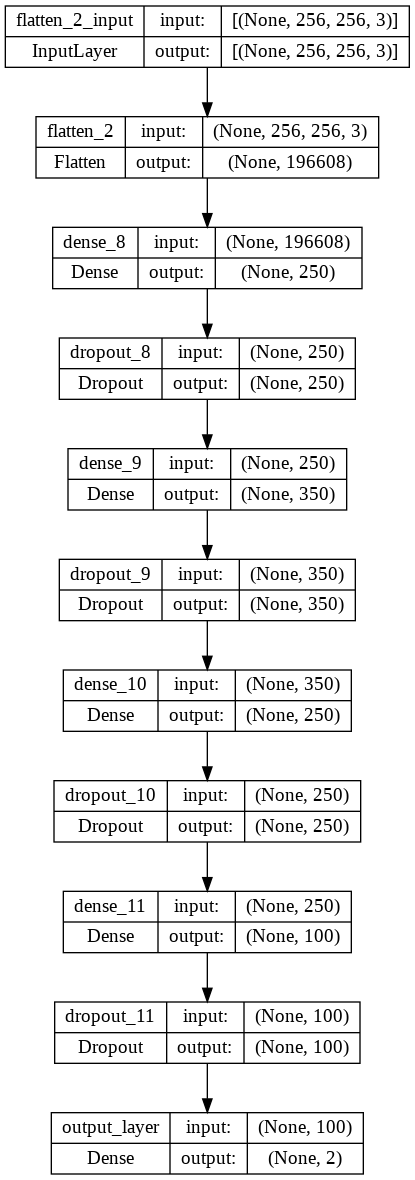

In [30]:
keras.utils.plot_model(model8, "model8.png", show_shapes=True) 

In [31]:
model8.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [32]:
## Train 
history8 = model8.fit(train_ds
                    ,validation_data =validation_ds
                    ,epochs=200
                    ,batch_size=64
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model8.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3),
                    ]                                                                                                           
                   )

Epoch 1/200
313/313 [==============================] - 5s 13ms/step - loss: 390.0663 - accuracy: 0.6441 - val_loss: 0.7292 - val_accuracy: 0.5587
Epoch 2/200
313/313 [==============================] - 4s 14ms/step - loss: 1.5978 - accuracy: 0.6146 - val_loss: 0.5777 - val_accuracy: 0.6488
Epoch 3/200
313/313 [==============================] - 3s 11ms/step - loss: 0.7931 - accuracy: 0.5537 - val_loss: 0.6175 - val_accuracy: 0.6025
Epoch 4/200
313/313 [==============================] - 3s 11ms/step - loss: 0.7026 - accuracy: 0.5440 - val_loss: 0.6818 - val_accuracy: 0.5175
Epoch 5/200
313/313 [==============================] - 3s 11ms/step - loss: 0.7118 - accuracy: 0.5177 - val_loss: 0.6881 - val_accuracy: 0.5075


In [33]:
model8 = tf.keras.models.load_model("DNN_model8.h5")
print(f"Test acc: {model8.evaluate(test_ds)[1]:.3f}")

31/31 [==============================] - 1s 20ms/step - loss: 0.7629 - accuracy: 0.6704
Test acc: 0.670


## Evaluate

In [34]:
history_dict8 = history8.history
history_dict8.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
history_df8=pd.DataFrame(history_dict8)
history_df8.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,390.066,0.644,0.729,0.559
1,1.598,0.615,0.578,0.649
2,0.793,0.554,0.617,0.603
3,0.703,0.544,0.682,0.517
4,0.712,0.518,0.688,0.507


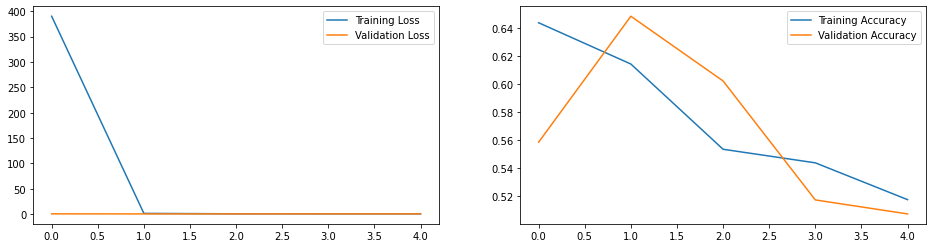

In [36]:
## Loss and acuracy
plot_history(history8)

In [37]:
test_pred8 = model8.predict(test_ds)
test_pred8 = np.argmax(test_pred8,axis = 1)
test_labels8 = np.concatenate([y for x, y in test_ds], axis=0) 

31/31 [==============================] - 1s 21ms/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

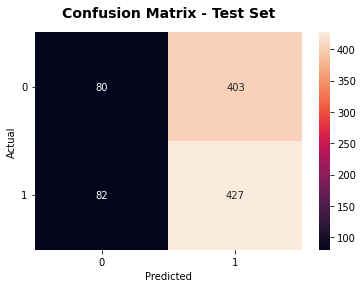

In [38]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels8,
    test_pred8,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 10) 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 14,weight = 'bold',pad=15)

In [ ]:
# 0 = without mask, 1 = with mask
# 992 images in test set, model missed 82 with mask and 403 without mask